<a href="https://colab.research.google.com/github/hannape/CNN-pierwsze-podejscie/blob/master/cnn_grid_with_scorer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# previous version, with hidden code and comments - cnn_scorer_not_working
from google.colab import drive
drive.mount('/content/drive')
from __future__ import print_function

import keras
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import GridSearchCV
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.utils import class_weight
from sklearn.metrics import  make_scorer
from sklearn.metrics import log_loss
K.set_image_dim_ordering('th')
import numpy as np
from sklearn import preprocessing
import glob
import os
import random
import functools
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train = numpy.load('drive/My Drive/X_train.npy')
y_train = numpy.load('drive/My Drive/y_train.npy')
X_test = numpy.load('drive/My Drive/X_test.npy')
y_test = numpy.load('drive/My Drive/y_test.npy')

X_train = X_train.reshape(X_train.shape[0], 1, 60, 87).astype('float32')
#X_val = X_val.reshape(X_val.shape[0], 1, 60, 87).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 60, 87).astype('float32')

input_shape = (1, 60, 87)
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using TensorFlow backend.


(30581, 1, 60, 87) (30581,)
(10793, 1, 60, 87) (10793,)


In [0]:
c_w = { 0:0.02, 1:0.98}
index = ['r%d' % x for x in range(len(y_train))]
a = [c_w[class_label] for class_label in y_train]
sample_weight_frame = pd.DataFrame(a, index = index)
score_params = {"sample_weight": sample_weight_frame}
#print(sample_weight_frame[0:5])


In [0]:
# https://github.com/keras-team/keras/issues/2115

### SCORERS
import tensorflow as tf
import functools
from functools import partial, update_wrapper

def my_score(y_true, y_pred, sample_weight): 
  return log_loss(y_true.values, y_pred, sample_weight=sample_weight.loc[y_true.index.values].values.reshape(-1), normalize=True)

def wrapped_partial(func, *args, **kwargs):
	partial_func = partial(func, *args, **kwargs)
	update_wrapper(partial_func, func)
	return partial_func

def binary_crossentropy_weigted(y_true, y_pred, class_weights):
	y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
	loss = K.mean(class_weights*(-y_true * K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred)),axis=-1)
	return loss

my_scorer = make_scorer(my_score,greater_is_better=False, needs_threshold=False,**score_params)  ## scoring for gridsearchCV
custom_loss = wrapped_partial(binary_crossentropy_weigted, class_weights=np.array([0.02, 0.98])) ## scoring for model.compile


## AUC METRIC
def as_keras_metric(method):
    import functools
    from keras import backend as K
    
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
  
auc_roc = as_keras_metric(tf.metrics.auc)


**BUILDING THE MODEL**

In [0]:
def make_model_modified(dense_layer_sizes,filters, kernel_size,pool_size,lr, drop_out):
        
    model = Sequential()
    model.add(Conv2D(filters, kernel_size,input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
   
    model.add(Flatten())
    model.add(Dense(dense_layer_sizes, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss=custom_loss,#'binary_crossentropy',#loss_2_args(y_true, y_pred)'',#loss='binary_crossentropy'
                  # co tu powinno wejść? o samo co do scoring w GridSearchCv? chyba nie: https://stackoverflow.com/questions/40572743/scikit-learn-grid-search-own-scoring-object-syntax
                  # my_score2(sample_weight = sample_weight_frame), <------------------- nie umiem zrobić by działał tutaj. Która funkcja? my_score czy my_scorer ?
                  # my_score2(sample_weight_frame) ---->  https://stackoverflow.com/questions/46858016/keras-custom-loss-function-to-pass-arguments-other-than-y-true-and-y-pred
                  # my_loss ---------------------------->też nie chodzi a chyba powinien, coś z formatem nie tak.  ERROR: 'Tensor' object has no attribute 'values'
                  # inne źródło: https://github.com/keras-team/keras/issues/2115
                  optimizer=keras.optimizers.Adam(lr),
                  metrics=['accuracy',auc_roc])

    return model

**GRID SEARCH**


In [0]:
my_classifier = KerasClassifier(make_model_modified)
validator = GridSearchCV(my_classifier,
                         param_grid={'dense_layer_sizes': [128],
                                     # epochs is avail for tuning even when not
                                     # an argument to model building function
                                     'epochs': [10,20,30],
                                     'filters': [10,10],
                                     'kernel_size': [(3,3)],
                                     'pool_size': [(2,2)],
                                     # 'class_weight': [{ 0:0.02, 1:0.98}],  <------------------------------- może w ten sposób? Ale t też tylko w grid searchu
                                     'batch_size': [32], 
                                     'drop_out':[0.5],#[0.2,0.5],
                                     'lr': [0.01,0.001,0.0001]},#[0.1,0.05,0.03,0.01, 0.001]}, 
                         scoring=my_scorer, n_jobs=1, refit=True, cv = 3)  ## SCORING ZMIENIONY na my_scorer (inne, np: 'roc_auc')

##https://stackoverflow.com/questions/49581104/sklearn-gridsearchcv-not-using-sample-weight-in-score-function

Epoch 1/10
20387/20387 [==============================] - 9s 466us/step - loss: 0.0827 - acc: 0.9885 - auc: 0.5193
Epoch 2/10
20387/20387 [==============================] - 8s 403us/step - loss: 0.0862 - acc: 0.9893 - auc: 0.5069
Epoch 3/10
20387/20387 [==============================] - 8s 401us/step - loss: 0.0862 - acc: 0.9893 - auc: 0.5042
Epoch 4/10
20387/20387 [==============================] - 8s 400us/step - loss: 0.0862 - acc: 0.9893 - auc: 0.5030
Epoch 5/10
20387/20387 [==============================] - 8s 405us/step - loss: 0.0862 - acc: 0.9893 - auc: 0.5024
Epoch 6/10
20387/20387 [==============================] - 8s 403us/step - loss: 0.0862 - acc: 0.9893 - auc: 0.5019
Epoch 7/10
20387/20387 [==============================] - 8s 401us/step - loss: 0.0862 - acc: 0.9893 - auc: 0.5016
Epoch 8/10
20387/20387 [==============================] - 8s 400us/step - loss: 0.0862 - acc: 0.9893 - auc: 0.5014
Epoch 9/10
20387/20387 [==============================] - 8s 403us/step - loss: 

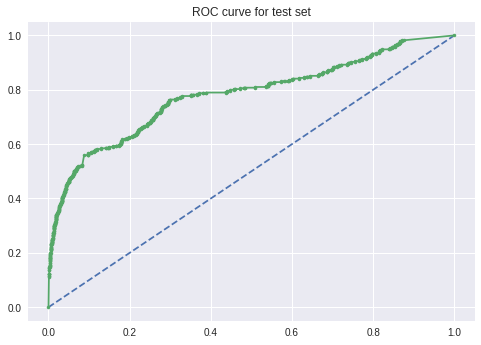

In [6]:
############

y_frame = pd.DataFrame(y_train, index=index)
grid_result = validator.fit(X_train, y_frame) #, class_weight = c_w)

############

print('The parameters of the best model are: ')
print(validator.best_params_)

best_model = validator.best_estimator_.model
metric_names = best_model.metrics_names
metric_values = best_model.evaluate(X_test, y_test)
for metric, value in zip(metric_names, metric_values):
  print(metric, ': ', value)
  
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))
  
# calculate AUC of final model on a test set
probs = best_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
#probs = probs[:, 1]
y_test2 = numpy.load('drive/My Drive/y_test.npy')  # osobno, bo inny wymiar

auc = roc_auc_score(y_test2, probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test2, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
plt.title('ROC curve for test set')
pyplot.show()

with open('drive/My Drive/kasi_obrona.txt', 'w') as f:
  print('Filename:', validator.best_params_, file=f)


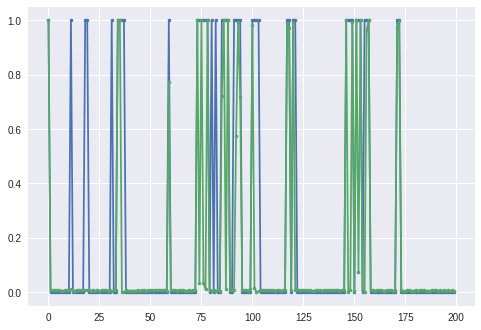

In [34]:
pyplot.plot(y_test2[10100:10300], marker='.')
pyplot.plot(probs[10100:10300], marker='.')